In [ ]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.utils import plot_model

import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

model_dir = './models/'
model_file = model_dir + 'inception_512_Preprocessed.keras'

Keras = 2.15.0
Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! unzip -o drive/MyDrive/dataset_19.zip
# ! unzip -o drive/MyDrive/Brain_MRI.zip

! pwd

Archive:  drive/MyDrive/dataset_19.zip
  inflating: dataset_19/glioma/Te-gl_0010.jpg  
  inflating: dataset_19/glioma/Te-gl_0016.jpg  
  inflating: dataset_19/glioma/Te-gl_0020.jpg  
  inflating: dataset_19/glioma/Te-gl_0026.jpg  
  inflating: dataset_19/glioma/Te-gl_0035.jpg  
  inflating: dataset_19/glioma/Te-gl_0041.jpg  
  inflating: dataset_19/glioma/Te-gl_0043.jpg  
  inflating: dataset_19/glioma/Te-gl_0044.jpg  
  inflating: dataset_19/glioma/Te-gl_0045.jpg  
  inflating: dataset_19/glioma/Te-gl_0057.jpg  
  inflating: dataset_19/glioma/Te-gl_0060.jpg  
  inflating: dataset_19/glioma/Te-gl_0075.jpg  
  inflating: dataset_19/glioma/Te-gl_0079.jpg  
  inflating: dataset_19/glioma/Te-gl_0085.jpg  
  inflating: dataset_19/glioma/Te-gl_0090.jpg  
  inflating: dataset_19/glioma/Te-gl_0107.jpg  
  inflating: dataset_19/glioma/Te-gl_0114.jpg  
  inflating: dataset_19/glioma/Te-gl_0125.jpg  
  inflating: dataset_19/glioma/Te-gl_0126.jpg  
  inflating: dataset_19/glioma/Te-gl_0127.jpg  
 

# Load the data

In [ ]:
# Data Directories
dir = "dataset_19/"
# validation_dir = "Brain_MRI/Testing/"

## Data Distribution

In [ ]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

pituitary     120
glioma        120
meningioma    120
notumor       120
dtype: int64

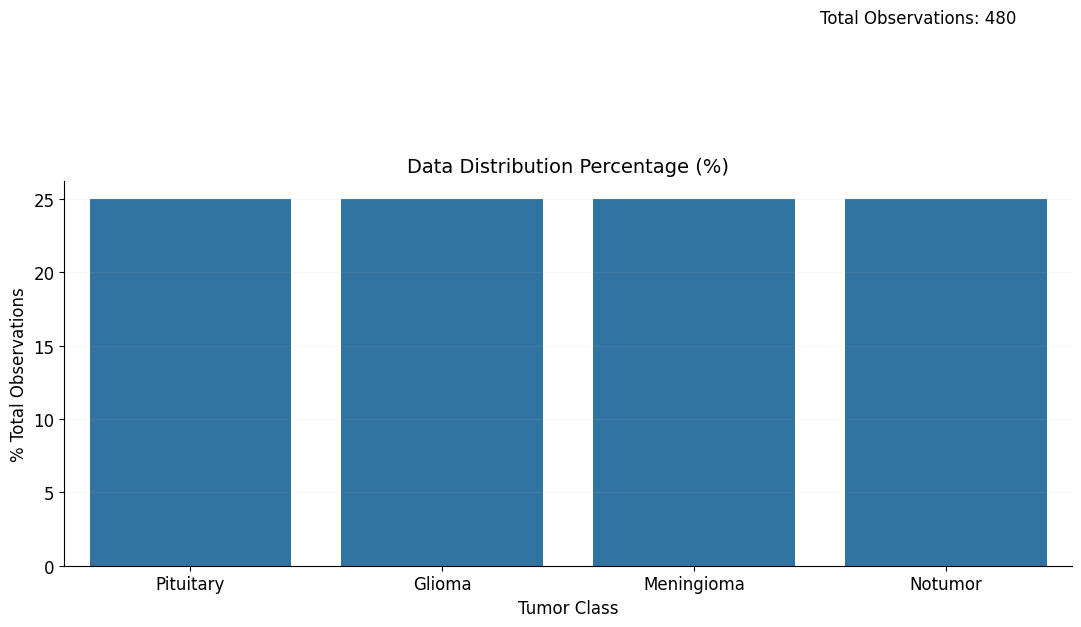

In [ ]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Preprocess Data


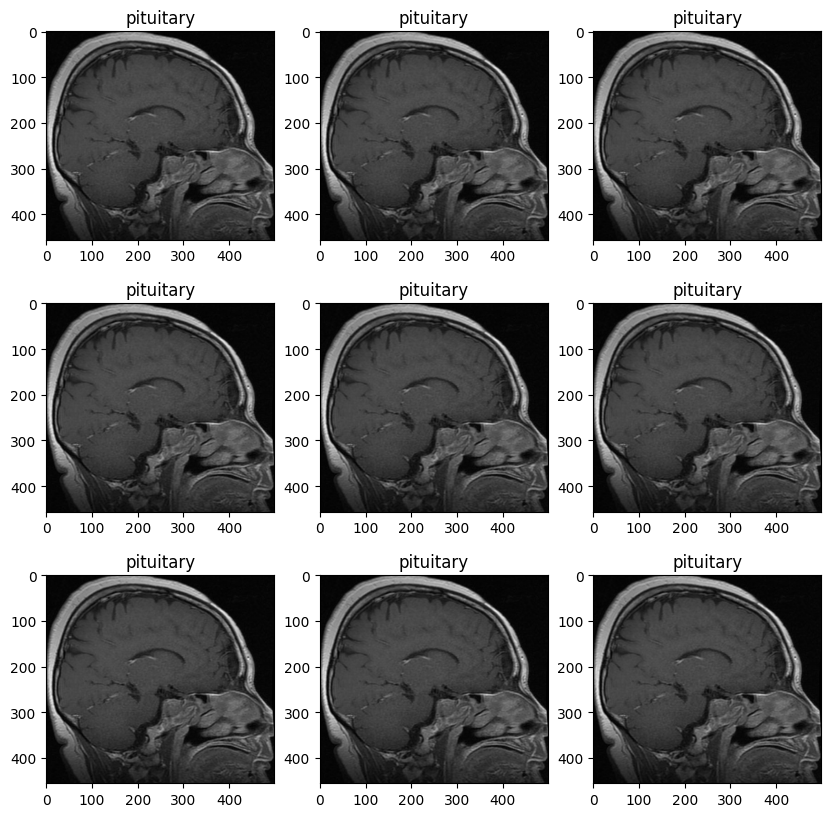

In [ ]:
from tqdm import tqdm
import cv2
import imutils

def crop_img(img):

	# Find extreme points on the image and crop the rectangular out

	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

	return new_img

def preprocess_images(directory):
    for dir in os.listdir(directory):
        path = os.path.join(directory, dir)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            cropped_img = crop_img(img)
            cv2.imwrite(img_path, cropped_img)

# Preprocess the images before generating data
preprocess_images(dir)

# Display 1 image using matplotlib
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for curr_index in os.listdir(dir):
        path = os.path.join(dir, curr_index)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            image = cv2.imread(img_path)
            plt.title(curr_index)
            plt.imshow(image)
            break
        break

## Splitting the data

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


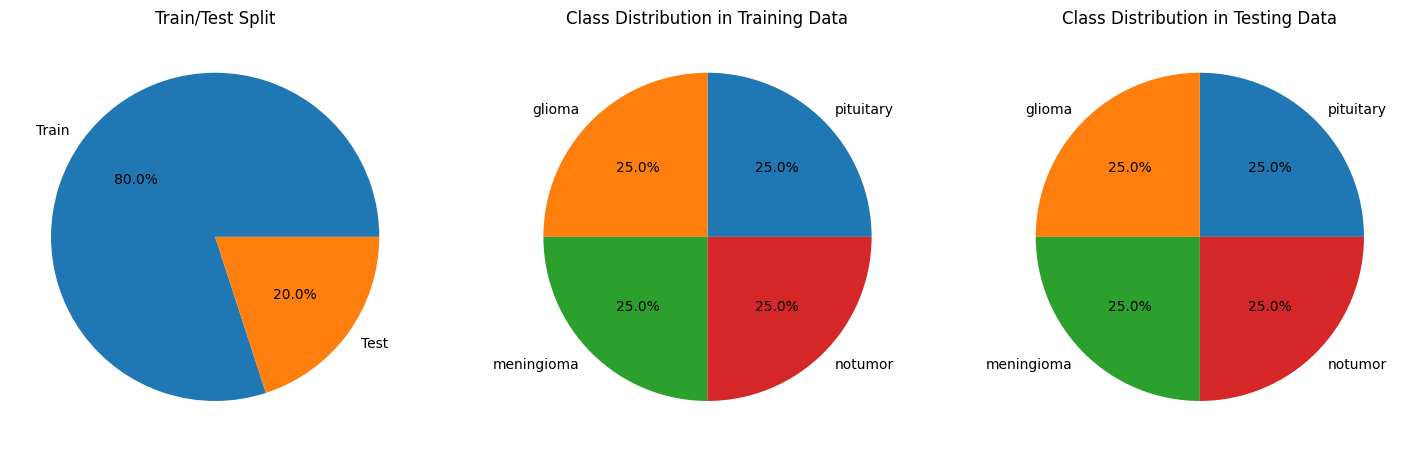

In [ ]:
classes = os.listdir(dir)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(512, 512),
    batch_size=32,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=(512, 512),
    batch_size=32,
    seed=42,
    subset='validation')


print(test_generator.class_indices)

# Get the number of samples in the training and testing data
num_train_samples = train_generator.samples
num_test_samples = test_generator.samples

# Get the distribution of classes in the training and testing data
train_class_distribution = np.bincount(train_generator.classes)
test_class_distribution = np.bincount(test_generator.classes)

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the train/test split
axes[0].pie([num_train_samples, num_test_samples], labels=['Train', 'Test'], autopct='%1.1f%%')
axes[0].set_title('Train/Test Split')

# Plot the distribution of classes in the training data
axes[1].pie(train_class_distribution, labels=classes, autopct='%1.1f%%')
axes[1].set_title('Class Distribution in Training Data')

# Plot the distribution of classes in the testing data
axes[2].pie(test_class_distribution, labels=classes, autopct='%1.1f%%')
axes[2].set_title('Class Distribution in Testing Data')

# Display the plots
plt.show()


# Training an inceptionV3 model

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
import tensorflow as tf

def modified_inception_v3(input_shape, num_classes):
    # Load the InceptionV3 model, excluding the top layer
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add custom top layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=output)

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Check if the model exists
if os.path.exists(model_file):
    # Load the model from the file
    model = load_model(model_file)
else:
    # Create a new model
    model = modified_inception_v3((512, 512, 3), len(classes))

plot_model(model, to_file= 'model.png', show_shapes=True, show_layer_names=True)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 255, 255, 32)         864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 255, 255, 32)         96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 255, 255, 32)         0         ['batch_normalization_18

# Train the model

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 1.0171 - accuracy: 0.6146
Epoch 1: val_loss improved from inf to 1.11031, saving model to ./models/inception_512_Preprocessed.keras
12/12 [==============================] - 50s 2s/step - loss: 1.0171 - accuracy: 0.6146 - val_loss: 1.1103 - val_accuracy: 0.5417
Epoch 2/50
12/12 [==============================] - ETA: 0s - loss: 0.3746 - accuracy: 0.8724
Epoch 2: val_loss did not improve from 1.11031
12/12 [==============================] - 17s 1s/step - loss: 0.3746 - accuracy: 0.8724 - val_loss: 1.2598 - val_accuracy: 0.4896
Epoch 3/50
12/12 [==============================] - ETA: 0s - loss: 0.1386 - accuracy: 0.9635
Epoch 3: val_loss did not improve from 1.11031
12/12 [==============================] - 17s 1s/step - loss: 0.1386 - accuracy: 0.9635 - val_loss: 1.3727 - val_accuracy: 0.4896
Epoch 4/50
12/12 [==============================] - ETA: 0s - loss: 0.0588 - accuracy: 0.9844
Epoch 4: val_loss did not improve fro

# Testing the Model

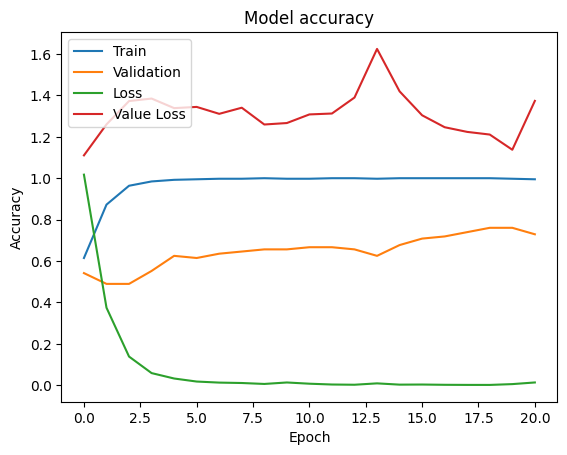

In [ ]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()

In [ ]:
# Validate the model with test data

model = keras.models.load_model(model_file)
model.evaluate(test_generator)

# Predict the output
predictions = model.predict(test_generator)
predictions = np.argmax(predictions, axis=1)

# Predict and Display image using matplotlib
plt.figure(figsize=(20, 20))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for X_batch, Y_batch in test_generator:
        image = X_batch[0]
        # Print Class
        plt.title("Predicted: " + classes[predictions[i]] + "\nActual: " + classes[np.argmax(Y_batch[i])])

        plt.imshow(image)
        break


OSError: No file or directory found at ./models/inception_512_Preprocessed.keras

# Model Visualisation (Evaluation)

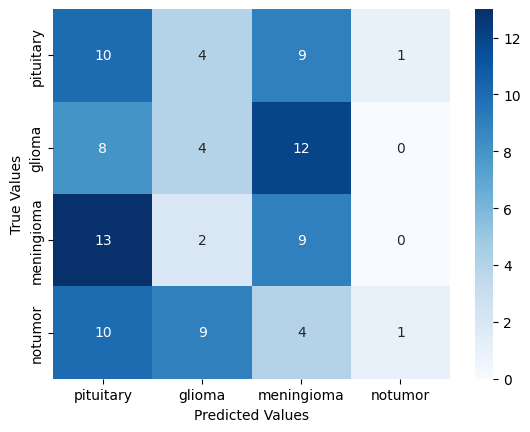

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_generator.classes, predictions)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score


def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean(
        [np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy


# Usage:
dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")

DSC: 0.22025168095737463, Sensitivity: 0.25, Specificity: 0.75, Accuracy: 0.25


In [ ]:
! mv models/inception_512.keras drive/MyDrive/
! mv models/inception_512_Preprocessed.keras drive/MyDrive/